@article{https://doi.org/10.1002/minf.202100321,
author = {Broccatelli, Fabio and Trager, Richard and Reutlinger, Michael and Karypis, George and Li, Mufei},
title = {Benchmarking Accuracy and Generalizability of Four Graph Neural Networks Using Large In Vitro ADME Datasets from Different Chemical Spaces},
journal = {Molecular Informatics},
doi = {https://doi.org/10.1002/minf.202100321},
url = {https://onlinelibrary.wiley.com/doi/abs/10.1002/minf.202100321},
}

creating a synthetic csv dataset

In [1]:
# import torch
# import pandas as pd

# # 'nan' for missing property labels
# data = {
#     'smiles': ['CCO', 'CO', 'C', 'O'] * 32,
#     'logP': torch.randn(127).numpy().tolist() + [float('nan')],
#     'logD': torch.randn(128).numpy().tolist()
# }
# df = pd.DataFrame(data)
# df.to_csv('syn_data.csv', index=False)

running the main.py script, arguments are defined inside the cell 

In [2]:
from dgllife.utils import atom_type_one_hot, atom_degree_one_hot, \
    atom_hybridization_one_hot, atom_is_aromatic_one_hot, \
    atom_chiral_tag_one_hot, atom_formal_charge_one_hot, atom_mass, \
    atom_implicit_valence_one_hot, BaseAtomFeaturizer, \
    ConcatFeaturizer, CanonicalBondFeaturizer
from functools import partial
from rdkit import Chem

atom_featurizer = BaseAtomFeaturizer(
    featurizer_funcs={
        'hv': ConcatFeaturizer(
            [partial(atom_degree_one_hot, allowable_set=[1, 2, 3, 4, 6]),
             partial(atom_type_one_hot, allowable_set=[
                 'B', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'Se', 'Si']),
             atom_chiral_tag_one_hot,
             partial(atom_formal_charge_one_hot, allowable_set=[-1, 0, 1]),
             partial(atom_hybridization_one_hot, allowable_set=[
                Chem.rdchem.HybridizationType.S,
                Chem.rdchem.HybridizationType.SP,
                Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3,
                Chem.rdchem.HybridizationType.SP3D2
             ]),
             partial(atom_implicit_valence_one_hot, allowable_set=list(range(4))),
             atom_is_aromatic_one_hot, atom_mass,
    ])}
)

if __name__ == '__main__':
    import pandas as pd

    from dgllife.data import MoleculeCSVDataset
    from dgllife.utils import SMILESToBigraph, RandomSplitter

    from configure import configs
    from run import main
    from utils import mkdir_p, setup

    # Provide the arguments directly here
    args = {
        'csv-path': '/Users/kseniiakholina/Desktop/dgl-lifesci-Kseniia/MTL/syn_data.csv',
        'model': 'MPNN',
        'mode': 'parallel',
        'num_epochs': 4000,
        'result_path': 'MTL_results',  # Fix the key name here
        'smiles-column': 'smiles',
        'tasks': ['logP', 'logD']  # Fix the task_names here
    }

    args['exp_name'] = '_'.join([args['model'], args['mode']])
    args.update(configs[args['exp_name']])

    # Setup for experiments
    mkdir_p(args['result_path'])  # Fix the key name here

    edge_featurizer = CanonicalBondFeaturizer(bond_data_field='he', self_loop=True)
    df = pd.read_csv(args['csv-path'])  # Fix the column name here

    smiles_to_g = SMILESToBigraph(add_self_loop=True, node_featurizer=atom_featurizer,
                                  edge_featurizer=edge_featurizer)

    dataset = MoleculeCSVDataset(
        df, smiles_to_g,
        smiles_column=args['smiles-column'],  # Fix the column name here
        cache_file_path=args['result_path'] + '/graph.bin',  # Fix the key name here
        task_names=args['tasks']  # Fix the task_names here
    )
    args['tasks'] = dataset.task_names
    args = setup(args)
    train_set, val_set, test_set = RandomSplitter.train_val_test_split(
        dataset, frac_train=0.8, frac_val=0.1,
        frac_test=0.1, random_state=0)

    main(args, atom_featurizer, edge_featurizer, train_set, val_set, test_set)


Directory MTL_results already exists.
Processing dgl graphs from scratch...
Epoch 1/4000 | training | averaged loss 0.4872 | averaged r2 0.0019 | averaged mae 0.8864
Epoch 1/4000 | validation | current r2 0.1513 | best r2 0.1513 | mae 0.8200
Epoch 2/4000 | training | averaged loss 0.4314 | averaged r2 0.0148 | averaged mae 0.8092
Epoch 2/4000 | validation | current r2 0.2288 | best r2 0.2288 | mae 0.8195
Epoch 3/4000 | training | averaged loss 0.4278 | averaged r2 0.0266 | averaged mae 0.8033
EarlyStopping counter: 1 out of 50
Epoch 3/4000 | validation | current r2 0.2194 | best r2 0.2288 | mae 0.8195
Epoch 4/4000 | training | averaged loss 0.4254 | averaged r2 0.0280 | averaged mae 0.8034
EarlyStopping counter: 2 out of 50
Epoch 4/4000 | validation | current r2 0.1572 | best r2 0.2288 | mae 0.8196
Epoch 5/4000 | training | averaged loss 0.4188 | averaged r2 0.0421 | averaged mae 0.7956
EarlyStopping counter: 3 out of 50
Epoch 5/4000 | validation | current r2 0.0375 | best r2 0.2288 | 

to run the main.py script:

In [3]:
# !python main.py -c /Users/kseniiakholina/Desktop/dgl-lifesci-Kseniia/MTL/syn_data.csv -m GCN --mode bypass -p Desktop/dgl-lifesci-Kseniia/MTL -s smiles -t logP,logD


The provided code is setting up a molecular property prediction task using the DGL-LifeSci library. It involves predicting two molecular properties, namely 'logP' (logarithm of the partition coefficient) and 'logD' (logarithm of the distribution coefficient). These properties are measures of a compound's hydrophobicity and lipophilicity.
The prediction is based on the molecular structure represented by SMILES strings, which are converted into graphs using the provided atom and bond featurizers.

Here's a breakdown of the code:

Atom Featurizer Setup: The code sets up an atom featurizer using different functions from the DGL-LifeSci library. These functions extract features from atoms, such as their type, degree, hybridization, chiral tag, formal charge, mass, implicit valence, and whether they are aromatic.

Task Definition: The code specifies that the prediction task involves two molecular properties: 'logP' and 'logD'. These are the targets to be predicted for each molecule in the dataset.

Dataset Preparation: The code reads a CSV file ('syn_data.csv') containing molecular data, including SMILES strings, and prepares the dataset using the MoleculeCSVDataset class from DGL-LifeSci. The molecule structures are converted into graphs, and the specified atom featurizer is applied to extract features from each atom in the molecules.

Model Training: The code trains a molecular property prediction model using the specified 'MPNN' (Message Passing Neural Network) model architecture. The model is trained using the training set, validated on the validation set, and tested on the test set. The number of epochs for training is set to 4000.

Overall, the code aims to develop a molecular property prediction model based on the provided molecular structures (SMILES strings) and predict two specific properties, 'logP' and 'logD', using the MPNN model with appropriate atom featurizers.



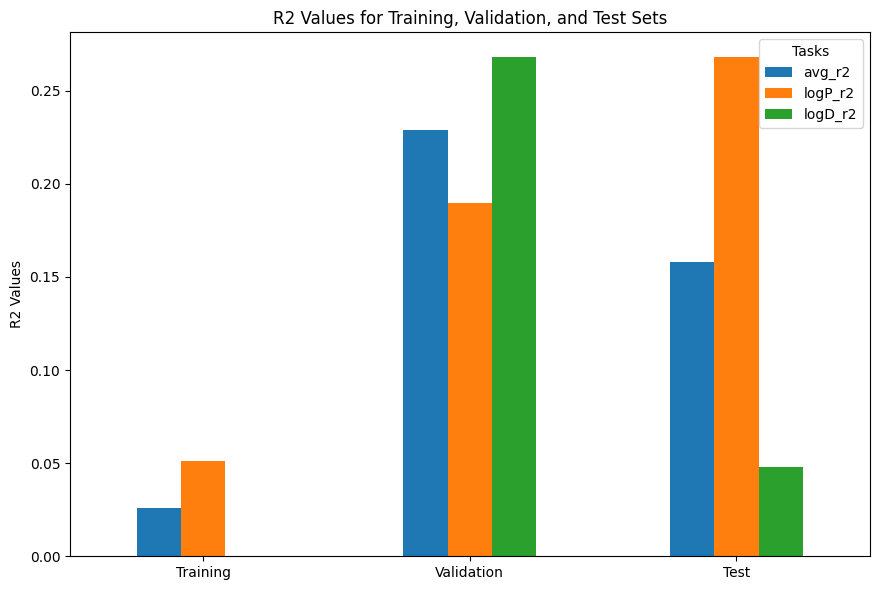

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# File path to the text file containing the R2 values
file_path = 'MTL_results/results.txt'

# Read the text file and extract its lines into a list
with open(file_path, 'r') as file:
    lines = file.readlines()

# Extract the R2 values for training, validation, and test sets
r2_values = {}
for line in lines[3:6]:
    values = line.strip().split('|')
    
    # Ensure there are enough elements in the line to avoid IndexError
    if len(values) >= 5:
        task = values[1].strip()
        avg_r2 = float(values[2].strip()) if values[2].strip() else None
        logP_r2 = float(values[3].strip()) if values[3].strip() else None
        logD_r2 = float(values[4].strip()) if values[4].strip() else None
        r2_values[task] = {'avg_r2': avg_r2, 'logP_r2': logP_r2, 'logD_r2': logD_r2}
    else:
        print(f"Warning: Line has insufficient elements: {line}")

# Create a Pandas DataFrame from the extracted R2 values
df = pd.DataFrame(r2_values).T

# Plot the bar chart using Matplotlib
ax = df.plot(kind='bar', figsize=(10, 6), rot=0)
ax.set_ylabel('R2 Values')
ax.set_title('R2 Values for Training, Validation, and Test Sets')
plt.legend(title='Tasks', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


{'Training': {'avg_mae': 0.889, 'logP_mae': 0.698, 'logD_mae': 1.08}, 'Validation': {'avg_mae': 0.889, 'logP_mae': 0.698, 'logD_mae': 1.08}, 'Test': {'avg_mae': 0.889, 'logP_mae': 0.698, 'logD_mae': 1.08}}


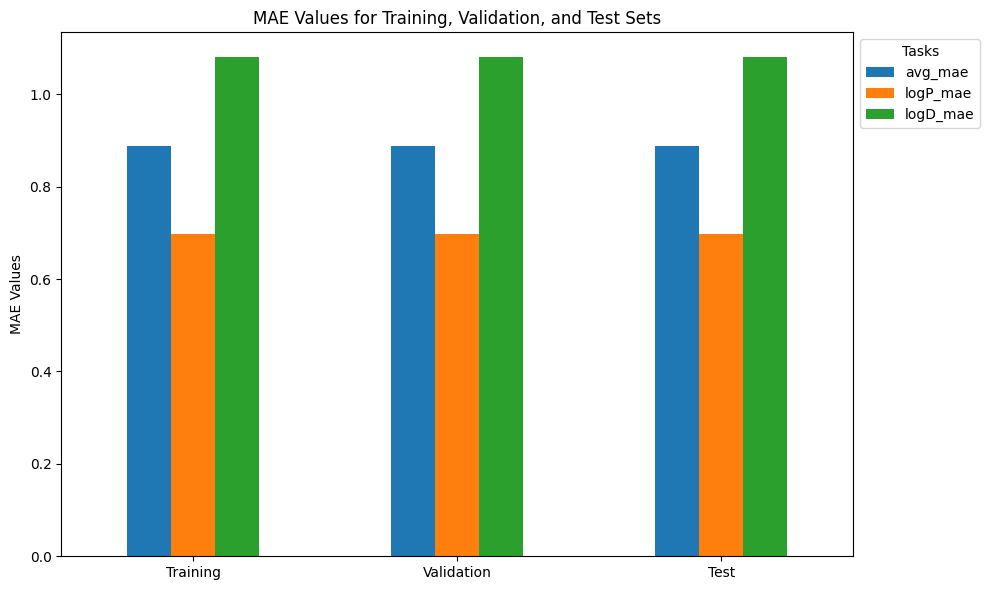

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# File path to the text file containing the R2 values
file_path = 'MTL_results/results.txt'

# Read the text file and extract its lines into a list
with open(file_path, 'r') as file:
    lines = file.readlines()

# Extract the mae values for training, validation, and test sets
mae_values = {}
for line in lines[11:14]:
    values = line.strip().split('|')
    
    # Ensure there are enough elements in the line to avoid IndexError
    if len(values) >= 5:
        task = values[1].strip()
        avg_mae = float(values[2].strip()) if values[2].strip() else None
        logP_mae = float(values[3].strip()) if values[3].strip() else None
        logD_mae = float(values[4].strip()) if values[4].strip() else None
        mae_values[task] = {'avg_mae': avg_r2, 'logP_mae': logP_r2, 'logD_mae': logD_r2}
    else:
        print(f"Warning: Line has insufficient elements: {line}")
print(mae_values)
df = pd.DataFrame(mae_values).T

ax = df.plot(kind='bar', figsize=(10, 6), rot=0)
ax.set_ylabel('MAE Values')
ax.set_title('MAE Values for Training, Validation, and Test Sets')
plt.legend(title='Tasks', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
